<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


In [1]:
# !pip install pyspark==3.1.2 -q
# !pip install findspark -q

In [2]:
# !wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-SN0101EN-SkillsNetwork/labs/Week2_FSDS/washing.parquet
# !mv washing.parquet?raw=true washing.parquet

--2024-06-12 11:22:25--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-SN0101EN-SkillsNetwork/labs/Week2_FSDS/washing.parquet
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112048 (109K) [binary/octet-stream]
Saving to: 'washing.parquet'

     0K .......... .......... .......... .......... .......... 45%  776K 0s
    50K .......... .......... .......... .......... .......... 91% 1.02M 0s
   100K .........                                             100% 30.8M=0.1s

2024-06-12 11:22:26 (970 KB/s) - 'washing.parquet' saved [112048/112048]

"mv" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable

In [1]:
import findspark
findspark.init()

In [2]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [3]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [4]:
df = spark.read.parquet('washing.parquet')
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     NULL|      77| NULL|        100|1547808723923|   NULL|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    NULL|      NULL|     NULL|    NULL| 1046|       NULL|1547808729917|   NULL|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    NULL|      NULL|       71|    NULL| NULL|       NULL|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     NULL|      75| NULL|         86|1547808738999|   NULL|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    NULL|      NULL|       75|    NULL| NULL|   

##### This is the feature transformation part of this exercise. Since our table is mixing schemas from different sensor data sources we are creating new features. In other word we use existing columns to calculate new ones. We only use min and max for now, but using more advanced aggregations as we've learned in week three may improve the results. We are calculating those aggregations over a sliding window "w". This window is defined in the SQL statement and basically reads the table by a one by one stride in direction of increasing timestamp. Whenever a row leaves the window a new one is included. Therefore this window is called sliding window (in contrast to tubling, time or count windows). More on this can be found here: https://flink.apache.org/news/2015/12/04/Introducing-windows.html

In [5]:
result = spark.sql("""
SELECT * from (
    SELECT
    min(temperature) over w as min_temperature,
    max(temperature) over w as max_temperature, 
    min(voltage) over w as min_voltage,
    max(voltage) over w as max_voltage,
    min(flowrate) over w as min_flowrate,
    max(flowrate) over w as max_flowrate,
    min(frequency) over w as min_frequency,
    max(frequency) over w as max_frequency,
    min(hardness) over w as min_hardness,
    max(hardness) over w as max_hardness,
    min(speed) over w as min_speed,
    max(speed) over w as max_speed
    FROM washing 
    WINDOW w AS (ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING) 
)
WHERE min_temperature is not null 
AND max_temperature is not null
AND min_voltage is not null
AND max_voltage is not null
AND min_flowrate is not null
AND max_flowrate is not null
AND min_frequency is not null
AND max_frequency is not null
AND min_hardness is not null
AND min_speed is not null
AND max_speed is not null   
""")

##### Since this table contains null values also our window might contain them. In case for a certain feature all values in that window are null we obtain also null. As we can see here (in my dataset) this is the case for 9 rows.

In [6]:
df.count()-result.count()

7

##### Now we import some classes from SparkML. PCA for the actual algorithm. Vectors for the data structure expected by PCA and VectorAssembler to transform data into these vector structures.

In [7]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

##### Let's define a vector transformation helper class which takes all our input features (result.columns) and created one additional column called "features" which contains all our input features as one single column wrapped in "DenseVector" objects

In [8]:
assembler = VectorAssembler(inputCols=result.columns, outputCol="features")

In [11]:
assembler

VectorAssembler_c493375e988c

##### Now we actually transform the data, note that this is highly optimized code and runs really fast in contrast if we had implemented it.

In [9]:
features = assembler.transform(result)


In [12]:
features

DataFrame[min_temperature: bigint, max_temperature: bigint, min_voltage: bigint, max_voltage: bigint, min_flowrate: bigint, max_flowrate: bigint, min_frequency: bigint, max_frequency: bigint, min_hardness: bigint, max_hardness: bigint, min_speed: bigint, max_speed: bigint, features: vector]

##### Let's have a look at how this new additional column "features" looks like:



In [14]:
features.rdd.map(lambda row: row.features).take(10)

[DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 71.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 80.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 72.0, 80.0, 1033.0, 1046.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0])]

##### Since the source data set has been prepared as a list of DenseVectors we can now apply PCA. Note that the first line again only prepares the algorithm by finding the transformation matrices (fit method)

In [15]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features)

##### Now we can actually transform the data. Let's have a look at the first 20 rows



In [16]:
result_pca = model.transform(features).select("pcaFeatures")
result_pca.show(truncate=False)

+---------------------------------------------------------+
|pcaFeatures                                              |
+---------------------------------------------------------+
|[1459.9789705815301,18.7452377818137,70.78430794789448]  |
|[1459.9954818287877,19.113431461685494,70.72738871418572]|
|[1460.0895843562396,20.969471062955705,70.75630600314615]|
|[1469.69939294206,20.4031246476478,62.0135696748022]     |
|[1469.7159041893176,20.77131832751961,61.956650441093444]|
|[1469.7128317339768,20.7907511172548,61.89610667824971]  |
|[1478.353026457406,20.294557029761734,71.67550104802777] |
|[1478.353026457406,20.294557029761734,71.67550104802777] |
|[1478.36860361393,20.260626897669297,71.63355353599675]  |
|[1478.36860361393,20.260626897669297,71.63355353599675]  |
|[1483.5412027685186,20.006222577534135,66.82710394276796]|
|[1483.5171090224458,20.867020421616676,66.86707301946433]|
|[1483.422426854405,19.87574823668773,66.93027077907936]  |
|[1483.422426854405,19.87574823668773,66

##### So we obtained three completely new columns which we can plot now. Let run a final check if the number of rows is the same.



In [17]:
result_pca.count()


2051

#####  Now we obtain a sample and read each of the three columns into a python list

In [18]:
rdd = result_pca.rdd.sample(False,0.8)


In [19]:
x = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[0]).collect()


In [20]:
y = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[1]).collect()


In [21]:
z = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[2]).collect()


##### Finally we plot the three lists and name each of them as dimension 1-3 in the plot

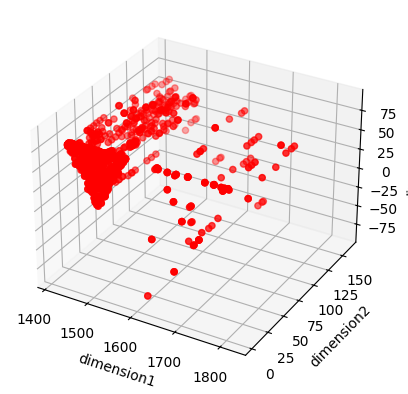

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')




ax.scatter(x,y,z, c='r', marker='o')

ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')

plt.show()

##### We can see two clusters in the data set. We can also see a third cluster which either can be outliers or a real cluster. In the next course we will actually learn how to compute clusters automatically. For now we know that the data indicates that there are two semi-stable states of the machine and sometime we see some anomalies since those data points don't fit into one of the two clusters.